In [19]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.addAtomIndices=True

from matplotlib import pyplot as plt

from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField

from openmm import unit, app, LangevinIntegrator

# Demonstration of how to use SerenityFF as an OpenFF plugin for a Simulation

### Create the ForceField object

Since SerenityFF only changes the partial charges of the system we need a OpenFF file as a base. In this repository a modified version is included. The only modification is that the `Electrostatics` handler is set to `SerenityFF`. To load the Forcefield correctly `load_plugins=True` has to be set, and the SerenityFF package has to be installed properly, which should link the plugin to the ForceField object.

In [2]:
ff_path = "../data/openff-2.0.0-serenity.offxml"

In [3]:
ff = ForceField(ff_path, load_plugins=True)

### Create a openff molecule

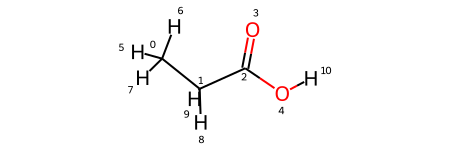

In [4]:
rdkit_mol = Chem.MolFromSmiles("CCC(=O)O")
rdkit_mol = Chem.AddHs(rdkit_mol)
AllChem.EmbedMolecule(rdkit_mol)
rdkit_mol

In [5]:
molecule = Molecule.from_rdkit(rdkit_mol)
topology = Topology.from_molecules(molecule)

In [6]:
partial_charges = ff.get_partial_charges(molecule=molecule)
partial_charges = partial_charges.value_in_unit(partial_charges.unit)
print(partial_charges)

[-0.35022952 -0.46300539  0.84514691 -0.63317813 -0.64303683  0.13599097
  0.13599097  0.13599097  0.16729995  0.16729995  0.50173014]


### Create a openmm system

In [7]:
openmm_system = ff.create_openmm_system(topology)

In [8]:
integrator = LangevinIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 4 * unit.femtosecond)

In [9]:
simulation = app.Simulation(topology.to_openmm(), openmm_system, integrator)

In [10]:
simulation.context.setPositions(molecule.conformers[0])

In [11]:
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)

In [12]:
simulation.reporters.append(app.StateDataReporter("./example_openmm.csv", 10, step=True, potentialEnergy=True, temperature=True))

### run a simulation

In [13]:
simulation.step(100)

In [14]:
df_openmm = pd.read_csv("./example_openmm.csv")

In [15]:
df_openmm

,"#""Step""",Potential Energy (kJ/mole),Temperature (K)
0,10,-103.476067,692.271793
1,20,-44.516418,273.685237
2,30,-99.618843,655.621622
3,40,-60.036942,402.778631
4,50,-102.386871,703.790335
5,60,-66.099594,398.005878
6,70,-90.892265,602.840270
7,80,-68.896545,431.701427
8,90,-91.364326,552.345995
9,100,-80.336533,450.220879


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


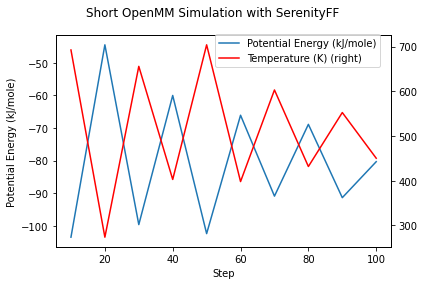

In [32]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
df_openmm.plot(x='#"Step"', y="Potential Energy (kJ/mole)", ax=ax)
df_openmm.plot(x='#"Step"', y="Temperature (K)", ax=ax1, secondary_y=True, color="red")
ax.set_ylabel("Potential Energy (kJ/mole)")
ax1.set_ylabel("Temperature (K)")
ax.set_xlabel("Step")
fig.suptitle("Short OpenMM Simulation with SerenityFF")
ax.legend().remove()
ax1.legend().remove()
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.show()

In [33]:
os.remove("./example_openmm.csv")

In [34]:
ff.get_partial_charges(molecule=Molecule.from_smiles("CCO"))

Quantity(value=array([-0.49584658,  0.16275335, -0.6912039 ,  0.14371002,  0.14371002,
        0.14371002,  0.06009469,  0.06009469,  0.47297767]), unit=elementary charge)